In [1]:
# Import all needed packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob

# 1. Camera Calibration

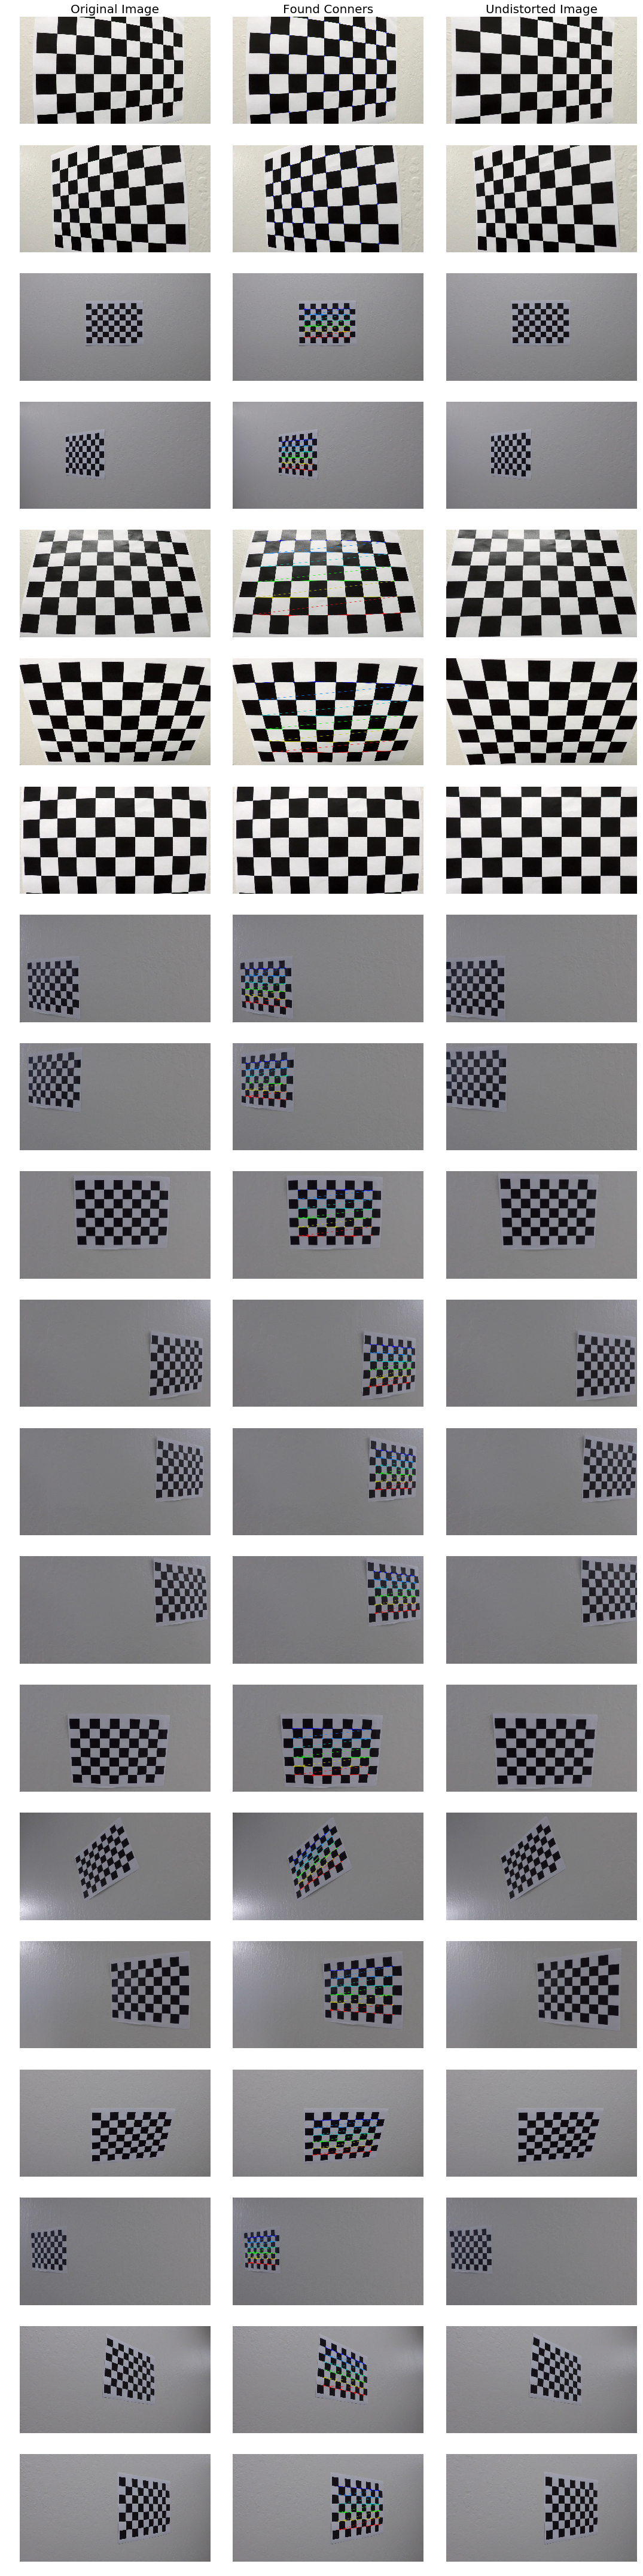

In [2]:
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# prepare object points
# different types of object points number
nx = 9
ny = 6

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

image_num = len(images)
fig=plt.figure(figsize=(15, 60))
counter = 0


# Plot original images and images with found corners
for idx, image_name in enumerate(images):
    # Read image
    img = mpimg.imread(image_name)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
            
        fig.add_subplot(image_num, 3, idx*3+1)
        plt.imshow(img)
        plt.axis('off')
        if idx == 0:
            plt.title("Original Image", fontsize=20)
            
        img1 = np.copy(img)
        cv2.drawChessboardCorners(img1, (nx,ny), corners, ret)
        fig.add_subplot(image_num, 3, idx*3+2)
        plt.imshow(img1)
        plt.axis('off')
        if idx == 0:
            plt.title("Found Conners", fontsize=20)
    else:
        fig.add_subplot(image_num, 3, idx*3+1)
        plt.imshow(img)
        plt.axis('off')
        if idx == 0:
            plt.title("Original Image", fontsize=20)
            
        img1 = np.copy(img)
        cv2.drawChessboardCorners(img1, (nx,ny), corners, ret)
        fig.add_subplot(image_num, 3, idx*3+2)
        plt.imshow(img1)
        plt.axis('off')
        if idx == 0:
            plt.title("Found Conners", fontsize=20)


# Add undistorted images to the plot
for idx, image_name in enumerate(images):
    # Read image
    img = mpimg.imread(image_name)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    fig.add_subplot(image_num, 3, idx*3+3)
    plt.imshow(undist)
    plt.axis('off')
    if idx == 0:
        plt.title("Undistorted Image", fontsize=20)
        
plt.tight_layout()
plt.show()

# Save dictionary pickle file
dic = {'imagePoints':imgpoints,'objectPoints':objpoints}
with open('calibrator.pickle', 'wb') as handle:
    pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load calibration results

In [2]:
# Load dictionary pickle file
dicPickle = pickle.load( open( "calibrator.pickle", "rb" ) )
objpoints = dicPickle["objectPoints"]
imgpoints = dicPickle["imagePoints"]

### Function of undistortion

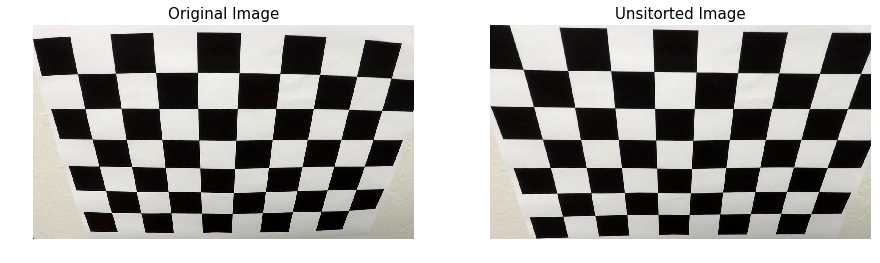

In [3]:
# Function for image undistortion
def calUndistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx) 
    return undist

# undistortion test
fig = plt.figure(figsize=(15, 10))
image = mpimg.imread('camera_cal/calibration2.jpg')
fig.add_subplot(1,2,1)
plt.imshow(image)  
plt.axis('off')
plt.title("Original Image", fontsize = 15)
undistorted = calUndistort(image, objpoints, imgpoints)
fig.add_subplot(1,2,2)
plt.imshow(undistorted)
plt.axis('off')
plt.title("Unsitorted Image", fontsize = 15)
plt.show()

# 2. Thresholding

In [4]:
# Function for x or y gradient threshold
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

# Magnitude of the gradient
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output

# Direction of the gradient
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # Take the absolute value of the x and y gradients
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output


### Results of different gradient thresholds

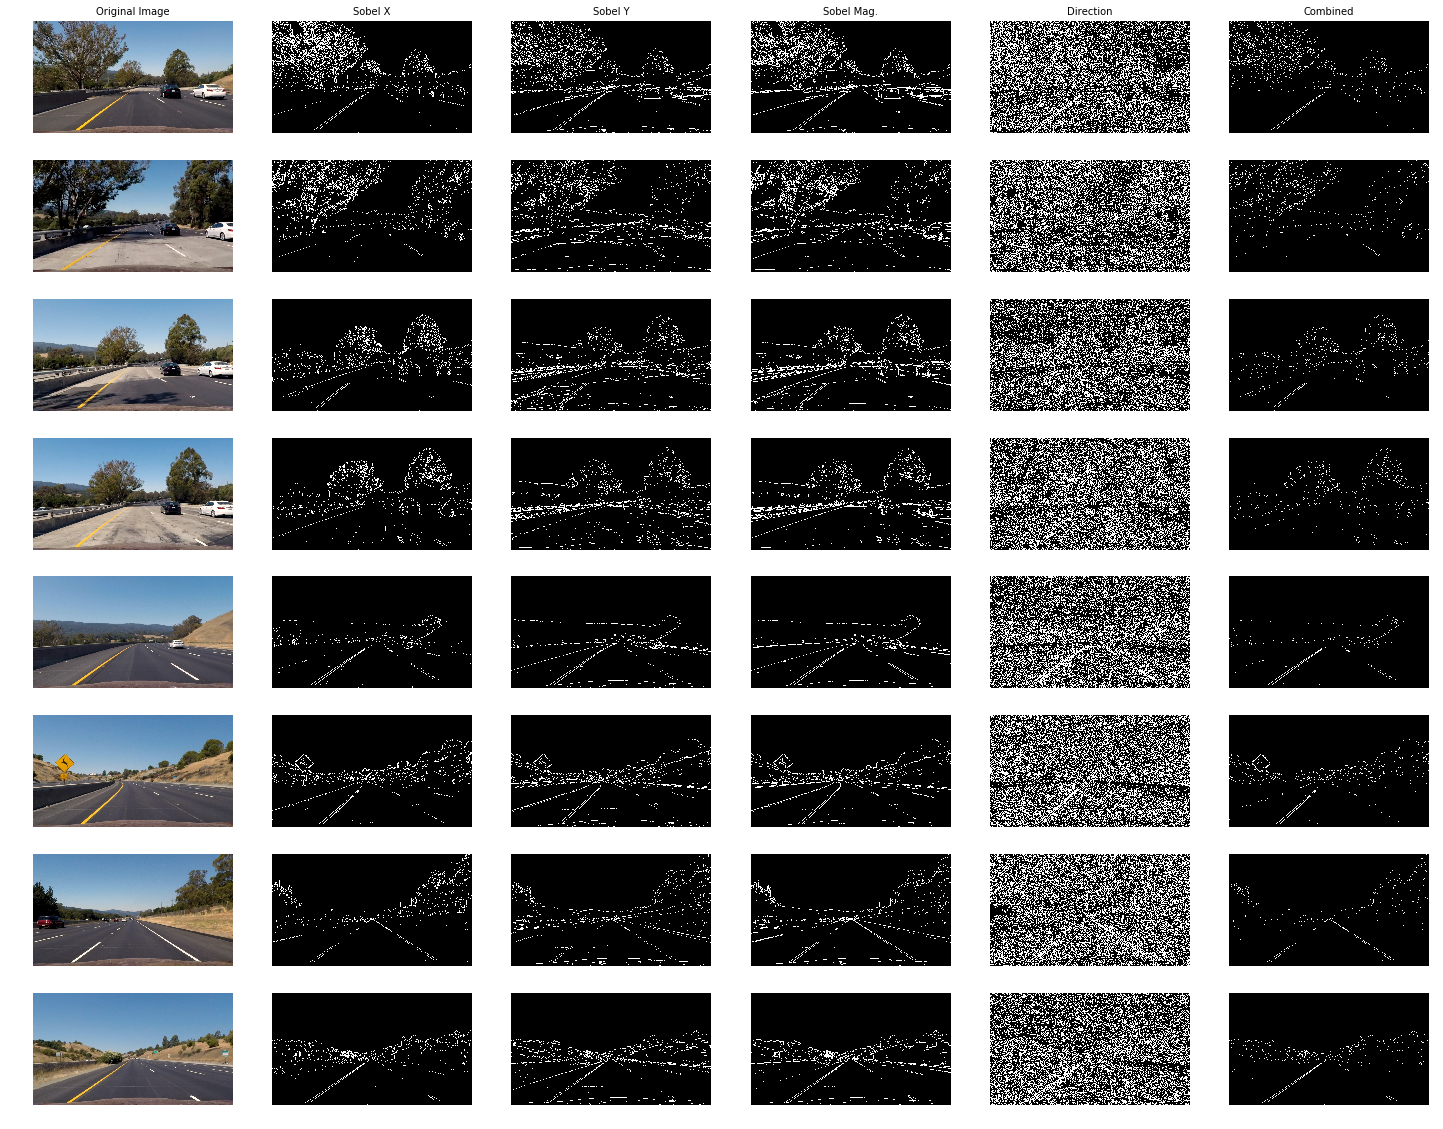

In [7]:
# Show different threshold results
directory = './test_images/*.jpg'
globDir = glob.glob(directory)
factors = [len(globDir),6]
fig = plt.figure(figsize=(25, 20))
counter = 1
for filename in globDir:
    img = mpimg.imread(filename)
    img = calUndistort(img, objpoints, imgpoints)
    # Undistorted image
    fig.add_subplot(factors[0],factors[1],counter)
    plt.imshow(img) 
    plt.axis('off')
    if counter < 6:
        plt.title('Original Image', fontsize=10)
    counter += 1 
    
    # Sobel X
    kSize = 3
    res1 = abs_sobel_thresh(img, 'x', (25, 100))
    fig.add_subplot(factors[0],factors[1],counter)
    plt.imshow(res1, cmap = 'gray') 
    plt.axis('off')
    if counter < 6:
        plt.title('Sobel X', fontsize=10)
    counter += 1
    
    # Sobel Y
    res2 = abs_sobel_thresh(img, 'y', (30, 100))
    fig.add_subplot(factors[0],factors[1],counter)
    plt.imshow(res2, cmap = 'gray') 
    plt.axis('off')
    if counter < 6:
        plt.title('Sobel Y', fontsize=10)
    counter += 1
    
    # Magnitude
    res3 = mag_thresh(img, kSize, (40, 200))
    fig.add_subplot(factors[0],factors[1],counter)
    plt.imshow(res3, cmap = 'gray') 
    plt.axis('off')
    if counter < 6:
        plt.title('Sobel Mag.', fontsize=10)
    counter += 1
    
    # Direction
    res4 = dir_threshold(img, kSize, (np.pi/6, 1.20))
    fig.add_subplot(factors[0],factors[1],counter)
    plt.imshow(res4, cmap = 'gray') 
    plt.axis('off')
    if counter < 6:
        plt.title('Direction', fontsize=10)
    counter += 1
    
    # Combination of sobel x and direction
    res_final = np.zeros_like(res1)
    res_final[(res1 == 1) & (res4 == 1)] = 1
    fig.add_subplot(factors[0],factors[1],counter)
    plt.imshow(res_final, cmap = 'gray') 
    plt.axis('off')
    if counter < 7:
        plt.title('Combined', fontsize=10)
    counter += 1

### Function of RGB Threshold

In [5]:
def rgb_select(img, channel = 'R', thresh=(0,255)):
    if channel == 'R':
        selected = img[:,:,0]
    if channel == 'G':
        selected = img[:,:,1]
    if channel == 'B':
        selected = img[:,:,2]
        
    binary = np.zeros_like(selected)
    binary[(selected > thresh[0]) & (selected <= thresh[1])] = 1
    return binary

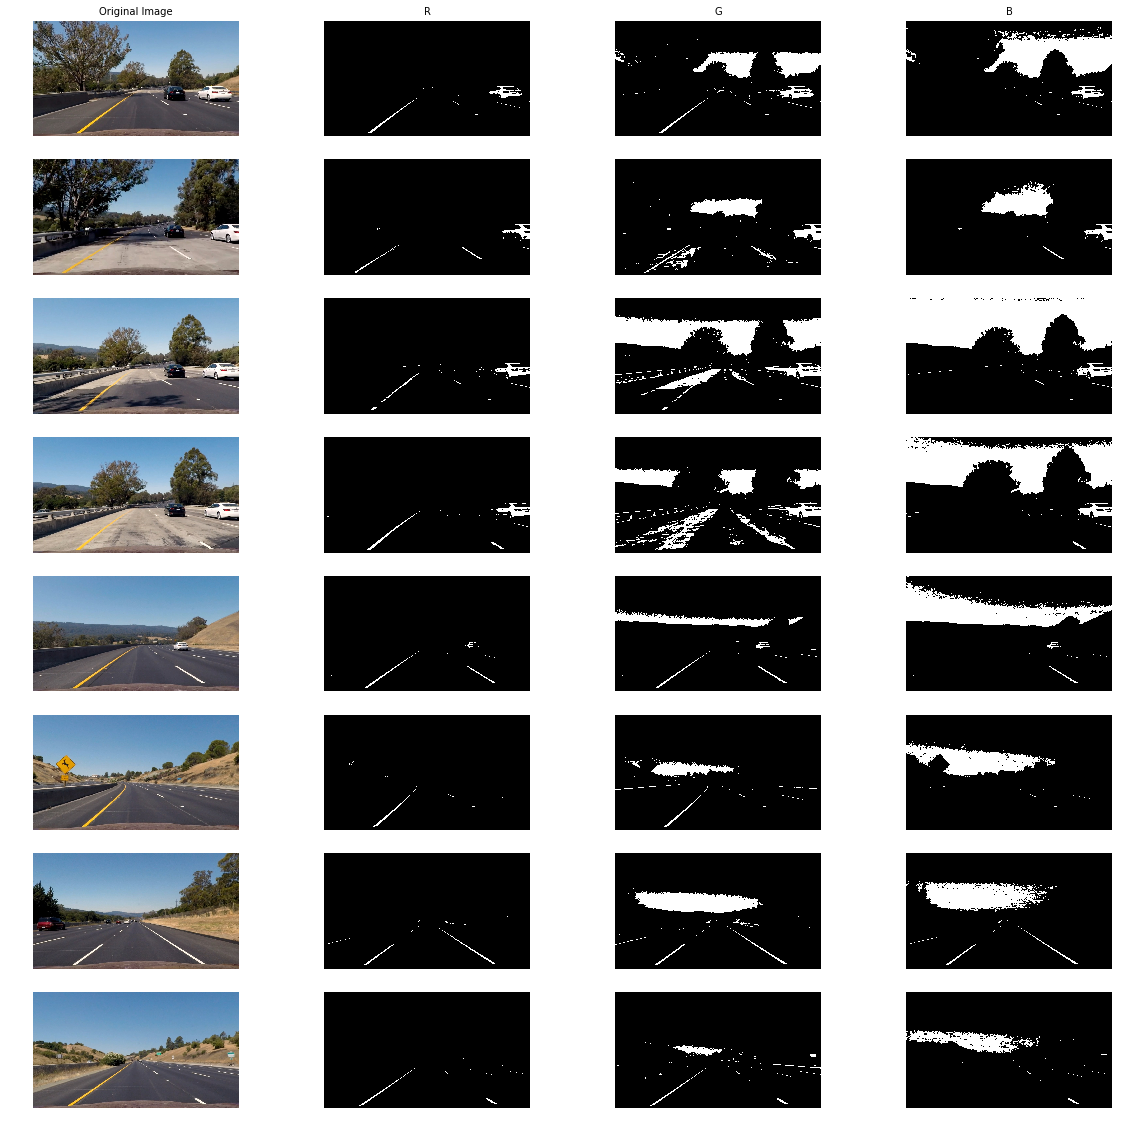

In [11]:
directory = './test_images/*.jpg'
globDir = glob.glob(directory)
factors = [len(globDir),4]
fig = plt.figure(figsize=(20, 20))
counter = 1
for filename in globDir:
    img = mpimg.imread(filename)
    img = calUndistort(img, objpoints, imgpoints)
    fig.add_subplot(factors[0],factors[1],counter)
    plt.imshow(img) 
    plt.axis('off')
    if counter < 5:
        plt.title('Original Image', fontsize=10)
    counter += 1 
    
    res1 = rgb_select(img, 'R', thresh=(230, 255))
    fig.add_subplot(factors[0],factors[1],counter)
    plt.imshow(res1, cmap = 'gray') 
    plt.axis('off')
    if counter < 5:
        plt.title('R', fontsize=10)
    counter += 1
    
    res2 = rgb_select(img, 'G', thresh=(180, 255))
    fig.add_subplot(factors[0],factors[1],counter)
    plt.imshow(res2, cmap = 'gray') 
    plt.axis('off')
    if counter < 5:
        plt.title('G', fontsize=10)
    counter += 1

    res3 = rgb_select(img, 'B', thresh=(200, 255))
    fig.add_subplot(factors[0],factors[1],counter)
    plt.imshow(res3, cmap = 'gray') 
    plt.axis('off')
    if counter < 5:
        plt.title('B', fontsize=10)
    counter += 1

### Function of HLS Threshold

In [6]:
def hls_select(img, channel = 'S', thresh=(0, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 'H':
        selected = hls[:,:,0]
    if channel == 'L':
        selected = hls[:,:,1]
    if channel == 'S':
        selected = hls[:,:,2]
        
    binary = np.zeros_like(selected)
    binary[(selected > thresh[0]) & (selected <= thresh[1])] = 1
    # Return a binary image of threshold result
    return binary

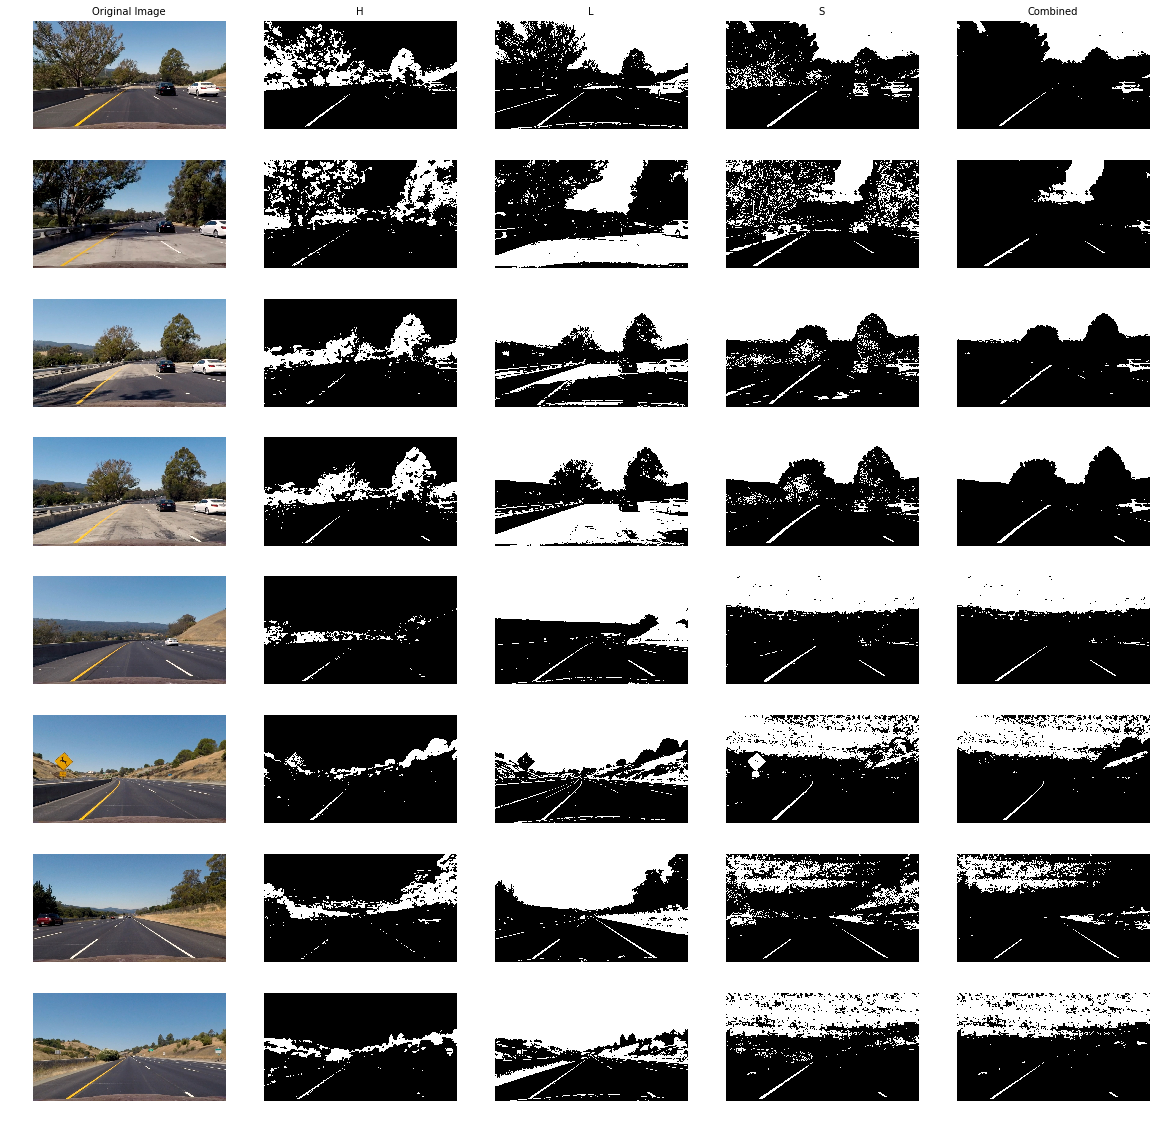

In [13]:
directory = './test_images/*.jpg'
globDir = glob.glob(directory)
factors = [len(globDir),5]
fig = plt.figure(figsize=(20, 20))
counter = 1
for filename in globDir:
    img = mpimg.imread(filename)
    img = calUndistort(img, objpoints, imgpoints)
    fig.add_subplot(factors[0],factors[1],counter)
    plt.imshow(img) 
    plt.axis('off')
    if counter < 5:
        plt.title('Original Image', fontsize=10)
    counter += 1 
    
    res1 = hls_select(img, 'H', thresh=(20, 100))
    fig.add_subplot(factors[0],factors[1],counter)
    plt.imshow(res1, cmap = 'gray') 
    plt.axis('off')
    if counter < 5:
        plt.title('H', fontsize=10)
    counter += 1
    
    res2 = hls_select(img, 'L', thresh=(120, 255))
    fig.add_subplot(factors[0],factors[1],counter)
    plt.imshow(res2, cmap = 'gray') 
    plt.axis('off')
    if counter < 5:
        plt.title('L', fontsize=10)
    counter += 1
    
    res3 = hls_select(img, thresh=(100, 255))
    fig.add_subplot(factors[0],factors[1],counter)
    plt.imshow(res3, cmap = 'gray') 
    plt.axis('off')
    if counter < 5:
        plt.title('S', fontsize=10)
    counter += 1
        
    res_final = np.zeros_like(res1)
    res_final[(res2 == 1) & (res3 == 1)] = 1
    fig.add_subplot(factors[0],factors[1],counter)
    plt.imshow(res_final, cmap = 'gray') 
    plt.axis('off')
    if counter < 7:
        plt.title('Combined', fontsize=10)
    counter += 1

### Combine Thresholds

In [7]:
def combined_thresh(img, l_thresh = (120,255), s_thresh=(100, 255), r_thresh=(230,255), g_thresh = (200,255), sobelx_thresh=(30,100), dir_thre=(0.6,1.20)):
    res1 = hls_select(img, 'L', s_thresh)
    res2 = hls_select(img, 'S', l_thresh)
    res3 = rgb_select(img, 'R', r_thresh)
    res4 = rgb_select(img, 'G', g_thresh)
    res5 = abs_sobel_thresh(img, 'x', sobelx_thresh)
    res6 = dir_threshold(img, 3, dir_thre)
    res_final = np.zeros_like(res1)
    res_final[((res1 == 1) & (res2 == 1)) | (res3 == 1) | ((res5 == 1) & (res6 == 1))] = 1
    return res_final

def region_of_interest(img, vertices):
    # apply the region of interest mask
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [vertices], 1)
    thresholded = cv2.bitwise_and(img, mask)
    return thresholded

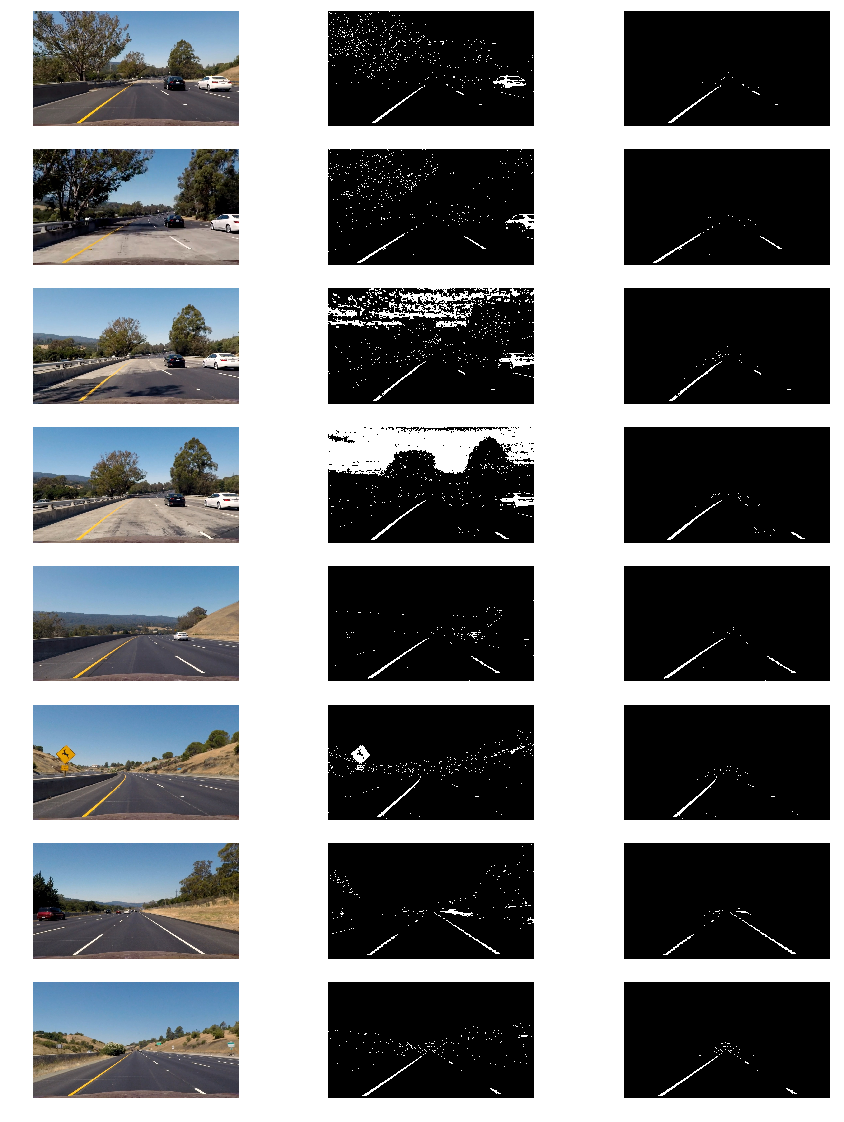

In [21]:
directory = './test_images/*.jpg'
globDir = glob.glob(directory)
factors = [len(globDir), 3]
fig = plt.figure(figsize=(15, 20))
counter = 1
height, width, color_channel = img.shape
vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
for filename in globDir:
    img = mpimg.imread(filename)
    img = calUndistort(img, objpoints, imgpoints)
    fig.add_subplot(factors[0],factors[1],counter)
    plt.imshow(img) 
    plt.axis('off')
    counter += 1 
    
    res_final = combined_thresh(img)
    fig.add_subplot(factors[0],factors[1],counter)
    plt.imshow(res_final, cmap = 'gray') 
    plt.axis('off')
    counter += 1
    
    res_final = region_of_interest(res_final, vertices)
    fig.add_subplot(factors[0],factors[1],counter)
    plt.imshow(res_final, cmap = 'gray') 
    plt.axis('off')
    counter += 1

# 3. Perspective Transform

In [8]:
# Function of perspective transform
def persp_tram(img, src, dst):
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped

### Image processing pipeline

In [9]:
def image_processing(img, vertices = []):
    # Vertices extracted manually for performing a perspective transform
    bottom_left = [275,680]
    bottom_right = [1030, 680]
    top_left = [597, 450]
    top_right = [683, 450]
    source = np.float32([bottom_left,bottom_right,top_right,top_left])

    # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
    bottom_left = [260,720]
    bottom_right = [900, 720]
    top_left = [260, 1]
    top_right = [900, 1]
    dst = np.float32([bottom_left,bottom_right,top_right,top_left])

    res_final = combined_thresh(img)
    height, width, color_channel = img.shape
    if not len(vertices):
        vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    res_final = region_of_interest(res_final, vertices)
    res_final = persp_tram(res_final, source, dst)
    
    return res_final

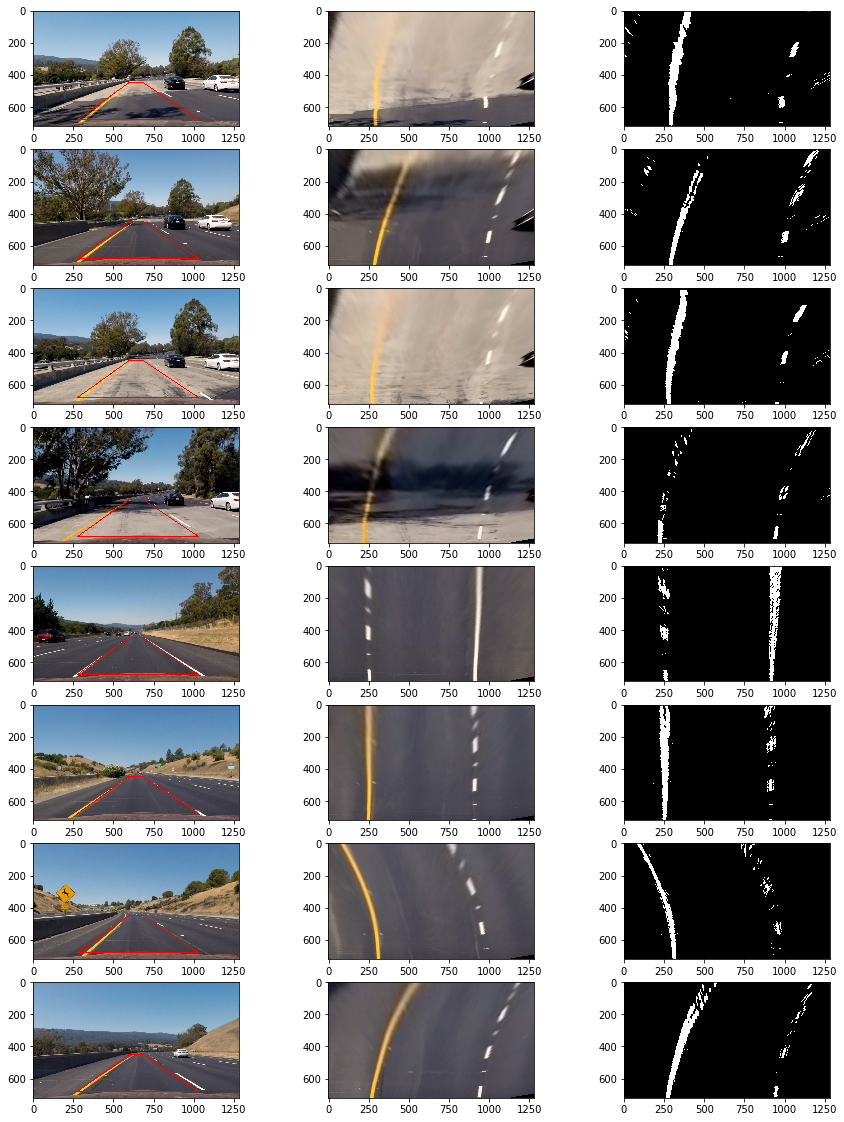

In [16]:
directory = './test_images/*.jpg'
globDir = glob.glob(directory)
factors = [len(globDir), 3]
fig = plt.figure(figsize=(15, 20))
counter = 1

# Vertices extracted manually for performing a perspective transform
bottom_left = [275,680]
bottom_right = [1030, 680]
top_left = [597, 450]
top_right = [683, 450]
pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
source = np.float32([bottom_left,bottom_right,top_right,top_left])

# Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
bottom_left = [260,720]
bottom_right = [900, 720]
top_left = [260, 1]
top_right = [900, 1]
dst = np.float32([bottom_left,bottom_right,top_right,top_left])


for filename in globDir:
    img = mpimg.imread(filename)
    img = calUndistort(img, objpoints, imgpoints)
    fig.add_subplot(factors[0],factors[1],counter)
    copy = img.copy()
    cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)
    plt.imshow(copy) 
    counter += 1 
    
    copy2 = img.copy()
    copy2 = persp_tram(copy2, source, dst)
    fig.add_subplot(factors[0],factors[1],counter)
    plt.imshow(copy2)
    counter += 1
    
    res_final = image_processing(img)
    fig.add_subplot(factors[0],factors[1],counter)
    plt.imshow(res_final, cmap = 'gray') 
    counter += 1

# 4. Lane Line Finding

### Peak Histogram

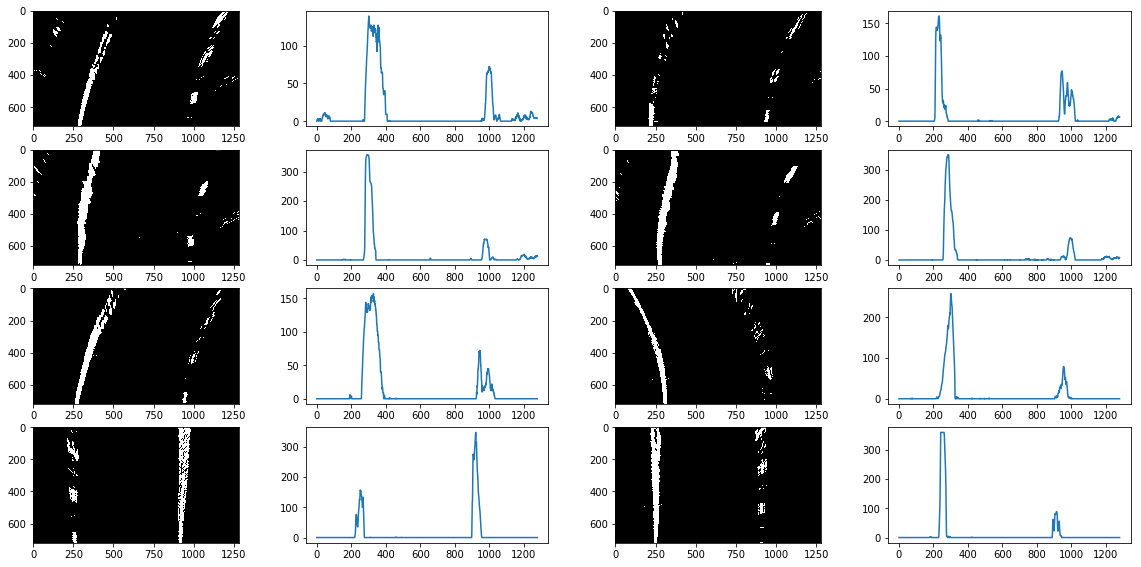

In [24]:
directory = './test_images/*.jpg'
globDir = glob.glob(directory)
factors = [len(globDir), 4]

fig = plt.figure(figsize=(20, 20))
counter = 1
for filename in globDir:
    img = cv2.imread(filename)
    img = calUndistort(img, objpoints, imgpoints)
    res_final = image_processing(img)
    
    fig.add_subplot(factors[0],factors[1],counter)
    counter += 1
    plt.imshow(res_final, cmap = 'gray') 
      
    fig.add_subplot(factors[0],factors[1],counter)
    counter += 1
    histogram = np.sum(res_final[res_final.shape[0]//2:,:], axis=0)
    plt.plot(histogram)

In [10]:
# Function of finding the fitting lane lines using histogram peak method
def hist_peak(binary_warped, nwindows = 12, margin = 100, minpix = 20, display = False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if display:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit

In [11]:
# Function of finding lane line fitting based on previous image frame
def sliding_window(binary_warped, left_fit, right_fit, margin = 100, display = False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if display:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return left_fit, right_fit

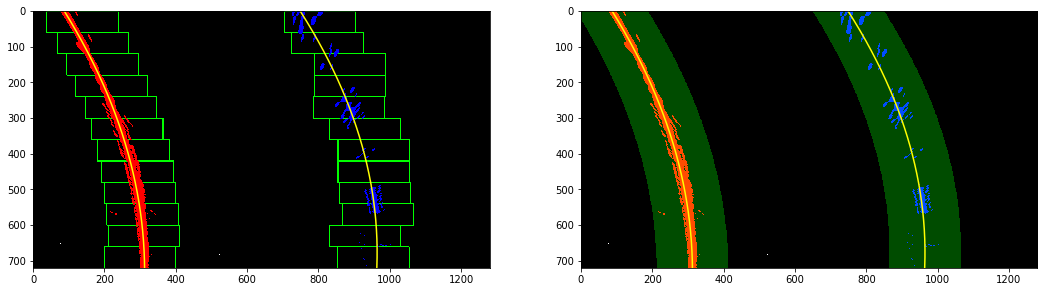

In [20]:
img = mpimg.imread('./test_images/test2.jpg')
img = calUndistort(img, objpoints, imgpoints)
binary_warped = image_processing(img)

fig = plt.figure(figsize=(18, 14))
fig.add_subplot(1,2,1)
left_fit, right_fit = hist_peak(binary_warped, display=True)

fig.add_subplot(1,2,2)
left_fit, right_fit = sliding_window(binary_warped, left_fit, right_fit, display=True)
plt.show()

### Draw found best fit lane line on the original undistorted image

In [18]:
def reverseProjector(undist, warped, src, dst, left_fit, right_fit, display = False):
    y = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    leftx = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    rightx = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]  
    
    # Create an image to draw the lines on
    warped_zero = np.zeros_like(warped).astype(np.uint8)
    warped_color = np.dstack((warped_zero, warped_zero, warped_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftx, y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    copy = warped_color.copy()
    cv2.fillPoly(warped_color, np.int32([pts]), (0,255,0))

    M_inv = cv2.getPerspectiveTransform(dst, src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    warped_new = cv2.warpPerspective(warped_color, M_inv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, warped_new, 0.4, 0)
    
    # Curvature Calculation
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/660 # meters per pixel in x dimension

    y_eval = np.max(y)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(y*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(y*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    curvature = (left_curverad + right_curverad) / 2
    
    original_pix = src[1][0] - src[0][0]
    warped_pix = dst[1][0] - dst[0][0]
    ratio = warped_pix / original_pix
    original_diff = warped.shape[1]/2 - src[0][0]
    car_mid = original_diff * ratio
    
    max_in = warped.shape[0]-1
    leftx_bottom = leftx[max_in]
    rightx_bottom = rightx[max_in]
    midx = (leftx_bottom + rightx_bottom) / 2
    lane_mid = midx - dst[0][0]
    
    offset = (car_mid - lane_mid) * xm_per_pix
    
    curvature_string = "Radius of curvature: %.2f m" % curvature
    if offset > 0:
        offset_string = "%.2f m right of center" % abs(offset)
    elif offset < 0:
        offset_string = "%.2f m left of center" % abs(offset)
    else:
        offset_string = "%.2f m middle of center" % abs(offset)
    
    cv2.putText(result, curvature_string , (100, 90), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,200,0), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,200,0), thickness=2)
    
    if display == True:
        plt.imshow(result)
        
    return result

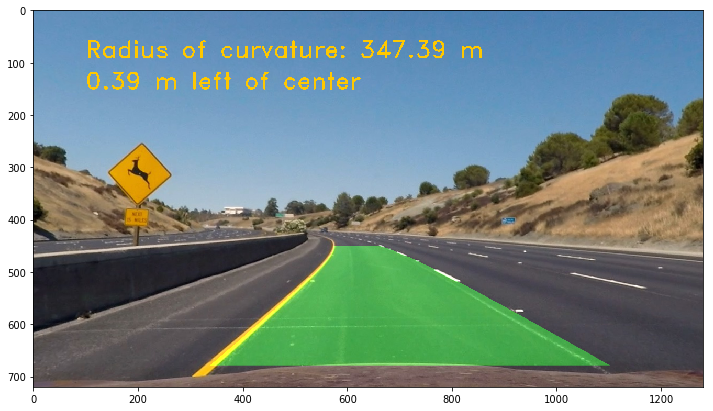

In [21]:
# Show one result
fig = plt.figure(figsize=(12, 10))
result = reverseProjector(img, binary_warped, source, dst, left_fit, right_fit, True)

# 5. Final Pipeline

In [22]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/660 # meters per pixel in x dimension
    
# Source points for perspective transform
bottom_left = [275,680]
bottom_right = [1030, 680]
top_left = [597, 450]
top_right = [683, 450]
src = np.float32([bottom_left,bottom_right,top_right,top_left])

# Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
bottom_left = [260,720]
bottom_right = [900, 720]
top_left = [260, 1]
top_right = [900, 1]
dst = np.float32([bottom_left,bottom_right,top_right,top_left])



# Define a class to receive the characteristics of each line detection
class Line():
    
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.left_fit_av = None
        self.right_fit_av = None
        #polynomial coefficients for the most recent fit
        self.left_fit_cur = None
        self.right_fit_cur = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
   
    # Video processing function
    def video_process(self, img):
        
        undistorted = calUndistort(img, objpoints, imgpoints)
        warped = image_processing(undistorted)

        if not self.detected:
            self.left_fit_cur, self.right_fit_cur = hist_peak(binary_warped)
            self.left_fit_av = self.left_fit_cur
            self.right_fit_av = self.right_fit_cur
            self.detected = True
            self.radius_of_curvature, self.line_base_pos = self.curv(undistorted, self.left_fit_cur, self.right_fit_cur)
        else:
            self.left_fit_cur, self.right_fit_cur = sliding_window(warped, self.left_fit_av, self.right_fit_av)
            self.left_fit_av = self.left_fit_av * 0.5 + self.left_fit_cur * 0.5
            self.right_fit_av = self.right_fit_av * 0.5 + self.right_fit_cur * 0.5
            self.radius_of_curvature, self.line_base_pos = self.curv(undistorted, self.left_fit_av, self.right_fit_av)
            
        res = self.reverseProjector(undistorted, warped, self.left_fit_av, self.right_fit_av)
        res = self.print_cur(res, self.radius_of_curvature, self.line_base_pos)
     
        return res

    # Reverse the lane finding result on each image
    def reverseProjector(self, undist, warped, left_fit, right_fit, display = False):
        
        # Position axis for all fit lane line points
        y = np.linspace(0, warped.shape[0]-1, warped.shape[0])
        leftx = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
        rightx = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]  

        # Create an image to draw the lines on
        warped_zero = np.zeros_like(warped).astype(np.uint8)
        warped_color = np.dstack((warped_zero, warped_zero, warped_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([leftx, y]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, y])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        copy = warped_color.copy()
        cv2.fillPoly(warped_color, np.int32([pts]), (0,255,0))

        M_inv = cv2.getPerspectiveTransform(dst, src)
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        warped_new = cv2.warpPerspective(warped_color, M_inv, (undist.shape[1], undist.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, warped_new, 0.4, 0)
        
        if display == True:
            plt.imshow(result)

        return result
    
    
    # Curvature Calculation
    def curv(self, result, left_fit, right_fit):
        
        # Y axis
        y = np.linspace(0, result.shape[0]-1, result.shape[0])
        leftx = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
        rightx = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]  

        # The bottom point y axis
        y_eval = np.max(y)
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(y*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(y*ym_per_pix, rightx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        # Radius of Curvature
        curvature = (left_curverad + right_curverad) / 2

        # Offset calculation
        original_pix = src[1][0] - src[0][0]
        warped_pix = dst[1][0] - dst[0][0]
        ratio = warped_pix / original_pix
        original_diff = result.shape[1]/2 - src[0][0]
        car_mid = original_diff * ratio
        max_in = result.shape[0]-1
        leftx_bottom = leftx[max_in]
        rightx_bottom = rightx[max_in]
        midx = (leftx_bottom + rightx_bottom) / 2
        lane_mid = midx - dst[0][0]

        # Offset result
        offset = (car_mid - lane_mid) * xm_per_pix
        
        return curvature, offset
    
    # Print radius of curvature on each image
    def print_cur(self, result, curvature, offset):
        
        # Radius of curvature
        curvature_string = "Radius of curvature: %.2f m" % curvature
        # Offset of the car center
        if offset > 0:
            offset_string = "%.2f m right of center" % abs(offset)
        elif offset < 0:
            offset_string = "%.2f m left of center" % abs(offset)
        else:
            offset_string = "%.2f m middle of center" % abs(offset)
        # Print the texts
        cv2.putText(result, curvature_string , (100, 90), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,200,0), thickness=2)
        cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,200,0), thickness=2)
        
        return result
    

# 6. Process the video

In [23]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# create a finding lane lines object
ll = Line()

# video processing
output = 'output_videos/project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
clip = clip.fl_image(ll.video_process)
clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [17:23<00:00,  1.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

